In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


![](ab_data.png)

In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime:

In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [21]:
daily_data['conversion']=((daily_data['converted']/daily_data['users_count'])*100)
daily_data.head()
d=daily_data[daily_data['timestamp'] == '2017-01-05']
d=d[d['group'] == 'A']
print('конверсия', round(d.iloc [0]['conversion'], 2), '%')

конверсия 12.32 %


In [22]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


                              ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

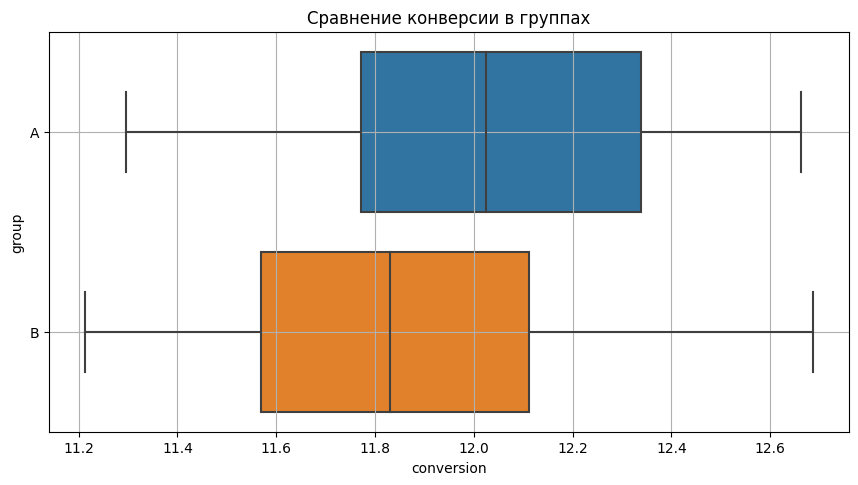

In [23]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [24]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

?Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

                                      КУМУЛЯТИВНЫЕ МЕТРИКИ

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

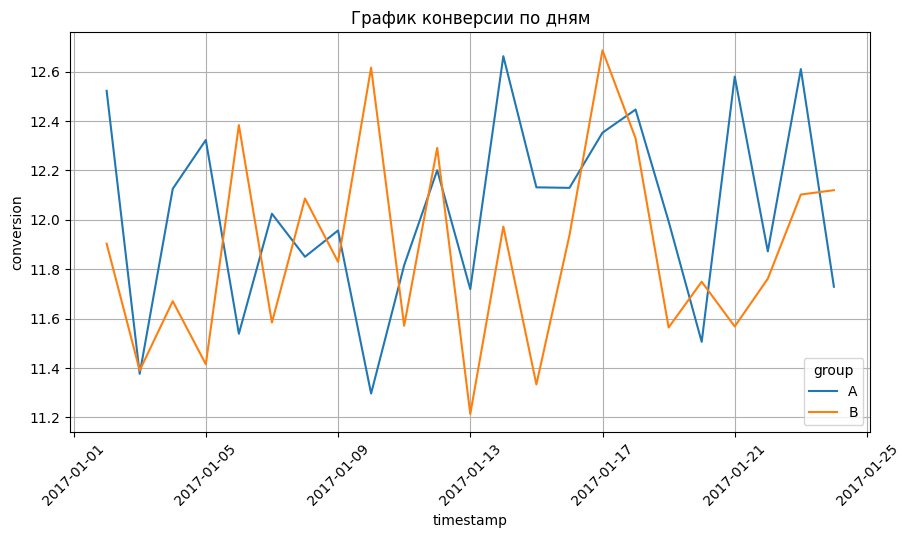

In [25]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [26]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

/var/folders/71/mrtyv_5x63jbx4zk2kls4n3m0000gn/T/ipykernel_27910/906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Обратите внимание, что в столбце с кумулятивной суммой за 2017-01-02 указано 9 435 пользователей. Сложите данные за 2017-01-02 и 2017-02-03 из столбца users_count — получите те же 9 435. Аналогично и для других дней. 

То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

In [27]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

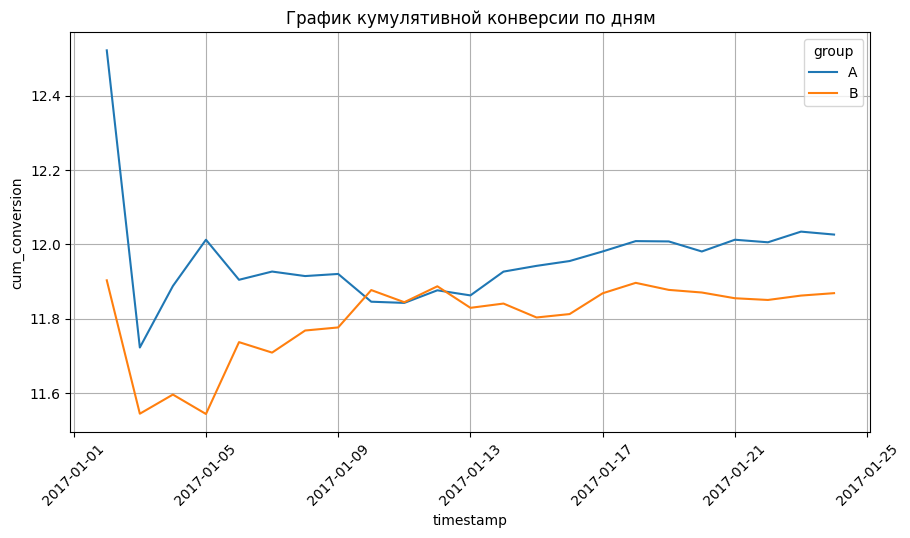

In [28]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

                               СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию proportions_ztest() из модуля statsmodels:

In [30]:
from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [31]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Зададим уровень значимости  и будем сравнивать полученное p-value с ним. По умолчанию функция proportions_ztest() возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [32]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [33]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


✏️ Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

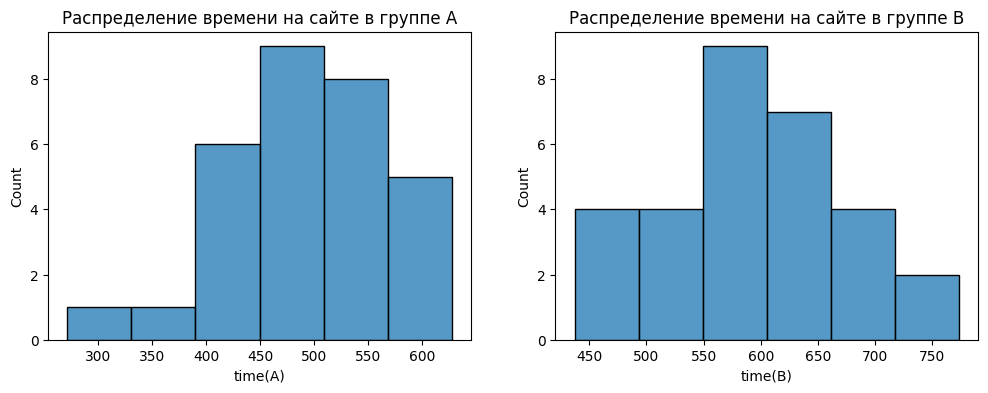

In [34]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [35]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [36]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


Обратите внимание: мы запрашивали значение p-value, округлённое до двух знаков после запятой, но на выводе получили 0.0 — значение только с одним знаком после запятой. Где же второй? Дело в том, что Python не выводит на конце числа больше одного нуля. Значит, 0.0 следует читать как 0.00. Без округления мы бы увидели значащие цифры далеко после запятой. Однако нас интересуют только две после запятой, потому что с такой точностью задан уровень значимости. Итак, в результате проведения T-теста мы получили , а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: среднее время, проводимое на сайте, в группе А меньше, чем в группе B.

Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая. 

⭐️ Обратите внимание, что мы опять же принимаем решение, исходя только из одной метрики, так как другими мы и не обладали. Мы проведём комплексный анализ результатов A/B-тестирования по нескольким метрикам в финальном задании модуля. А пока предлагаем вам решить несколько задач!